# ElephantScale - Introduction to TensorFlow 2

## Requirements

In order to run this notebook, you'll need to have TensorFlow 2 installed on your machine. This tutorial was written with the following version of TensorFlow:

In [1]:
# !pip install tensorflow
# !pip install tensorflow-datasets

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
print("TensorFlow Version {}".format(tf.__version__))
print("TensorFlow Datasets Version {}".format(tfds.__version__))

TensorFlow Version 2.1.0
TensorFlow Datasets Version 2.1.0


## 1. TensorFlow Data Pipelines with TF Datasets

One of the best parts about TensorFlow 2 is the [TensorFlow Datasets](https://www.tensorflow.org/datasets/api_docs/python/tfds) package. Previously, it took a lot of work to get our data into a format where TF models could make use of them. With the `tfds` package, we can easily load tons of industry-standard datasets for benchmarking, or we can easily create our own. 

In the section below, we'll demonstrate some of the core functionality of the `tfds` package, including some common operations you'll use to get ready to train some models!

We can start by viewing all available public datasets in tfds by calling `tfds.list_builders()`.  We can load any of these datasets by passing the string value of the dataset in question into a `tfds.load()` call. 

In [3]:
# List all available curated datasets in tfds
tfds.list_builders()

['abstract_reasoning',
 'aeslc',
 'aflw2k3d',
 'amazon_us_reviews',
 'arc',
 'bair_robot_pushing_small',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'cos_e',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'diabetic_retinopathy_detection',
 'div2k',
 'dmlab',
 'downsampled_imagenet',
 'dsprites',
 'dtd',
 'duke_ultrasound',
 'dummy_dataset_shared_generator',
 'dummy_mnist',
 'emnist',
 'eraser_multi_rc',
 'esnli',
 'eurosat',
 'fashion_mnist',
 'flic',
 'flores',
 'food101',
 'gap',
 'gigaword',
 'glue',
 'gr

For this demonstration, we'll keep it simple and work with the [MNIST dataset](https://www.tensorflow.org/datasets/catalog/mnist). 
Before we get started, let's visualize some examples to see what our dataset images actually looks like!

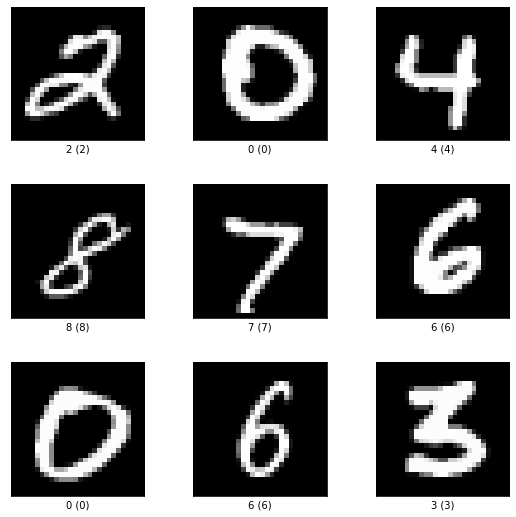

In [4]:
ds_test, info = tfds.load("mnist", split="test", with_info=True)
fig = tfds.show_examples(info, ds_test)

### Loading MNIST Dataset

We'll want to pass in some keyword arguments to ensure that we get the dataset back in the most useful format for our task.  We'll pass in the following keyword arguments: 

* `with_info=True`, so that the builder returns a `DatasetInfo` object containing any metadata we might need about the dataset in question.  
<br>
* `as_supervised=True`, so that the dataset returned is split into corresponding images and labels, saving us the extra preprocessing of separating the images and labels.  
<br>
* `split=['train', 'test']`, so that the dataset returns our data already split into training and testing sets. This will return our data as a tuple in the form of `(train, test)`, so we can easily unpack this tuple and bind each to the appropriate variable. (Note that if we only wanted 10% of the training dataset, we could easily specify that here by passing in `split='train[:10%]`!)

In [5]:
# Load pretrained datasets using tfds
(train, test), info = tfds.load('mnist', with_info=True, as_supervised=True, split=['train', 'test'])

Next, we'll do some preprocessing of our data. Since we're working with images, we'll normalize the individual pixel values in each image by dividing them by 255. We'll also cast the dataset from its current data type, `uint8`, to the data type TF models expect, `float32`. 

Note that we pass the corresponding label along in our function, although we don't do anything to it. This just ensures that our labels stay matched up with their corresponding images during the preprocessing stage. 

In [6]:
# Create a sample function for processing dataset
def normalize_img(image, label):
    """Normalizes images; uint8 -> float32"""
    
    return tf.cast(image,tf.float32) / 255., label

Now that we've created a function that does our preprocessing for us, we can easily use a `.map()` call and pass in the function we created. TF will automatically transform the entire dataset. Better yet, by including the flag `num_parallel_calls=tf.data.experimental.AUTOTUNE`, TF will automatically parallelize this process as much as possible, depending on the machine it is being run on it. This provides a significant speed up when working on GPU/TPU machines! 

(If you want to specify this yourself in CPU-only training, a good heuristic is to set `num_parallel_calls` to the number of cores on your CPU.)

The following cell contains a typical training data pipeline. 

In [7]:
# Use function with Map call to transform entire dataset. This is a 
# standard training pipeline in TF

train = train.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train = train.cache()
train.shuffle(info.splits['train'].num_examples)
train = train.batch(128)
# The next line enables async batch fetching, and is considered a best practice
train.prefetch(tf.data.experimental.AUTOTUNE)

<DatasetV1Adapter shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int64)>

#### Caching, Batching, Shuffling, and Prefetching

As we can see from the example code, tfds does a wonderful job of simplifying the most common operations needed when creating a data pipeline for modeling. 

In the next cell, we repeat the same process from our training pipeline to create our testing pipeline. Here, there are a few specific differences. 

In the **_training pipeline_**, we:

1. Perform data transformations/preprocessing
2. Cache our training dataset
3. Shuffle our training data
4. Create minibatches 
5. Enable async prefetching, so that we aren't slowed down by I/O operations

Our testing pipeline is similar,with some distinct differences. Pay attention to the order of each. 

In the **_testing pipeline_**, we:

1. Perform data transformations/preprocessing
2. Batch our testing dataset
3. Cache our testing dataset
4. Enable async prefetching, so that we aren't slowed down by I/O operations

Did you catch the difference? 

In our testing pipeline, we preprocess and batch our data before caching. This is different from our training pipeline, where we preprocess, cache, and then handle everything else. This is because of the nature of a test set--in order to have an apples-to-apples comparison of the performance of each epoch, they need to be tested on the exact same batches, in the exact same order. Thus, we batch, and then cache.  Conversely, in our training dataset, we want some randomness to switch things up. Therefore, we perform the longest running operation once (normalizing the pixel values of every image in our training dataset), and then cache. We then batch and shuffle our cached dataset each epoch, ensuring we have a random draw of data for our minibatches for each different training step. 

In [8]:
# Shuffle, batch, and cache testing data 
test = test.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = test.batch(128)
test = test.cache()
test = test.prefetch(tf.data.experimental.AUTOTUNE)

What if we want to work with our own custom dataset?

We can always create a TF dataset out a Numpy array! The cell below contains a commented out line that shows how to do that using `tf.data.Dataset` package, which is closely related to the tfds package. We won't go deeply into working with our own data, but this should be enough to get you started! For more information on loading datasets from common formats like numpy, csv, and pandas dataframes, check out the corresponding [tensorflow documentation](https://www.tensorflow.org/tutorials/load_data/numpy).

In [9]:
# Create a tf dataset using your own data

# train_dataset_example = tf.data.Dataset.from_tensor_slices(train_examples, train_labels)

# 2. Training Models with TF and Keras

### 2.1 Basic Models 

Now that we have our dataset processed and squared away, it's time to build our first neural network! We'll start by building a basic **_Multi-Layer Perceptron_**, the workhorse of Deep Learning. 

In TensorFlow 2, Keras has become one of the most important modules in TensorFlow. In the cell below, we'll use it to import the `Sequential` model that we'll use to construct our neural network, as well as `Flatten` and `Dense` layers that we'll use. 

In [10]:
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential

#### Best Practice

One of the most time consuming aspects in Deep Learning is tuning your model's hyperparameters. Small changes to things like the number of neurons in a layer or the activation function used can result in significant differences in performance. As we still haven't mastered the theory behind understanding how neural networks do what they do, there are no hard and fast rules to follow regarding which hyperparameters to use. As a result, you'll typically need to run experiments with different combinations of hyperparameters to find the best fit for your network. 

As a pro-tip, always assume you're going to need to experiment with different values for hyperparameters, and specify them separately, as a cell of variables for each one. This will act as a "configuration" cell of sorts, allowing you to quickly iterate by changing values for these variables. It's much easier to change them here, then it is in the TF model! 

#### Understanding Our Hyperparameters

We're going to build a neural network with the following architecture:

Input layer --> Flatten Layer --> Hidden Layer 1 --> Hidden Layer 2 --> Output Layer

Let's break this down piece by piece:

1. **_Input Layer_** - We don't actually have to touch this. TF will handle it for us. All we need to do is specify the shape of the inputs we'll be passing then network, which is typically handled by the first layer after the input layer.  
<br> 
2. **_Flatten Layer_** - Recall that a Multi-Layer Perceptron requires it's input to be passed in as a 1D Vector. Our image is natively in the shape of a (28, 28, 1) Tensor (we can interpret this as a 28x28 pixel grayscale image. A dolor image would be 28x28x3). We can vectorize these images by just concatenating all 28 rows of pixels into a single row with 784 pixels (28 x 28 = 784).  We aren't strictly required to use a Flatten layer here, as we could always just reshape the images ourselves using numpy.  However, it's much easier to just add a Flatten layer to do the work for us! In this layer, we just need to specify the input shape, and it will transform the input images into a 1D vector that the following Dense layer can work with. Note that since this layer doesn't have any trainable parameters (because it's not going to learn anything, just reshape images from one specified shape to another), it's not considered a hidden layer.   
<br>   
3. **_Hidden Layer 1_** - In Multi-Layer Perceptrons, any layer with learnable parameters that isn't an input or output layer is referred to as a *hidden layer*.  This is because they aren't directly observable from the input or outputs of the network, and we can't really interpret what it is they're learning. In this neural network, our hidden layers are going to consist of the most common type of layer used in Deep Learning--a *Dense* layer. These layers are often referred to as **_Fully Connected Layers_**, because each neuron in this layer takes input from every neuron in the previous layer, and every neuron in this layer passes it's output of it's activation function as input to the neurons in the next layer. In Dense layers, we need to specify 2 required parameters: the number of neurons in this layer, and the activation function neurons in this layer should use. For the first layer, we'll use `512` neurons, and a `'sigmoid` activation function.   
<br>  
4. **_Hidden Layer 2_** - We expect this layer is going to learn features at a higher level of abstraction than the first hidden layer, because it is deeper in the network. Here, we'll use 256 neurons, and a `'sigmoid'` activation function.   
<br>  
5. **_Output Layer_** - The output layer is just another Dense layer, but with a twist. In this layer, we need it to have 1 neuron for every possible class in the dataset. In this case, that's 10 neurons. We'll also set the activation function to `'softmax'`, so that the network will output a vector of probabilities corresponding to each class. 

### Other Hyperparameters

We'll also set these other hyperparameters:

* `NUM_CLASSES = 10`, because there are 10 possible classes in our dataset.
* `ACTIVATION = 'sigmoid'`, because we'll start by using a sigmoid activation function on our Dense layers
* `INPUT_SHAPE = info.features['image']`, to get the shape of the images we'll be passing to our Flatten layer. Note that this code may change if you're working with a different dataset than MNIST (especially if not an image classification dataset)
* `EPOCHS = 10`. 1 Epoch is one full round of training on the entire training dataset. 
* `LOSS = 'sparse_categorical_crossentropy'`, because we need to tell the network which loss function to use to grade itself with when comparing its predictions to the actual labels. 
* `OPTIMIZER = 'sgd'`, because we want the network to use stochastic gradient descent as the optimizer to adjust the weights of each neuron as the model learns with practice. 


In [19]:
# Specify Hyperparameters separately, to allow for quicker 
# experimentation and tuning

LAYER_1_NEURONS = 512
LAYER_2_NEURONS = 256
NUM_CLASSES = 10
ACTIVATION = 'sigmoid'
INPUT_SHAPE = info.features['image'].shape # we could also hardcode (28,28,1), but it's safer to get the shape directly from the dataset
EPOCHS = 20
LOSS = 'sparse_categorical_crossentropy'
OPTIMIZER = 'sgd'

Now that we've set the hyperparameters, creating the model is quite simple!

In [20]:
model = Sequential(Flatten(input_shape=INPUT_SHAPE))
model.add(Dense(LAYER_1_NEURONS, activation=ACTIVATION))
model.add(Dense(LAYER_2_NEURONS, activation=ACTIVATION))
model.add(Dense(NUM_CLASSES, activation='softmax'))

Let's take a look at the shape of the network we've created by calling `model.summary()` in the cell below. 

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                2570      
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
_________________________________________________________________


This is a relatively small model, but it still has over 500,000 trainable parameters. Put in a more mathematical way, this network is learning to find the decision boundaries between the 10 digits in a 535,818-dimensional space!

#### Compiling and Training

Once we've built our model, we still need to **_compile_** the model before training it.  This is the step where TensorFlow generates that awesome computational graph under the hood for us. 

In [22]:
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])

Now that we have a compiled model, we can train our model by calling `model.fit()` and passing in:

* our `train` dataset
* `epochs=EPOCHS`, as a keyword argument
* `validation_data=test`, to tell our model we want it to try it's performance on the test set at the end of each epoch. 

In [23]:
training_history = model.fit(train, epochs=EPOCHS, validation_data=test)

Epoch 1/20
469/469 [==============================] - 2s 5ms/step - loss: 2.2748 - accuracy: 0.1907 - val_loss: 2.2315 - val_accuracy: 0.2064
Epoch 2/20
469/469 [==============================] - 1s 3ms/step - loss: 2.1907 - accuracy: 0.4280 - val_loss: 2.1399 - val_accuracy: 0.4943
Epoch 3/20
469/469 [==============================] - 1s 3ms/step - loss: 2.0840 - accuracy: 0.5754 - val_loss: 2.0100 - val_accuracy: 0.6279
Epoch 4/20
469/469 [==============================] - 1s 3ms/step - loss: 1.9281 - accuracy: 0.6450 - val_loss: 1.8199 - val_accuracy: 0.6858
Epoch 5/20
469/469 [==============================] - 1s 3ms/step - loss: 1.7109 - accuracy: 0.6860 - val_loss: 1.5740 - val_accuracy: 0.7233
Epoch 6/20
469/469 [==============================] - 1s 3ms/step - loss: 1.4601 - accuracy: 0.7235 - val_loss: 1.3232 - val_accuracy: 0.7569
Epoch 7/20
469/469 [==============================] - 1s 3ms/step - loss: 1.2303 - accuracy: 0.7546 - val_loss: 1.1159 - val_accuracy: 0.7806
Epoch 

### Interpreting Training Results

TensorFlow is great about giving metrics to follow during training operations. This is really handy for us, as we can see the model learning in real time! Note that in the printouts above, we see `loss` and `accuracy`, as well as `val_loss` and `val_accuracy`. The first two correspond to our model's performance on the training set, while the ones that start with `val_` correspond to our testing set. Performance on your testing set is what matters! With enough epochs, your model will always begin to **_overfit_** to your training set. This is because it is beginning to memorize specific features about the images in the training set, as opposed to learning generalizable features that transfer over to other handwritten digits. Model overfitting is bad, and we want to identify it and take steps to avoid it whenever possible. 

### Visualzing Training Results

When you call `model.fit()`, the model will return a `History` object containing a bunch of great information about the model's performance during each step of the training. The cell below demonstrates how to use [matplotlib](https://matplotlib.org/3.2.1/contents.html) to graph the training and testing metrics as trendlines, which makes it much easier to interpret and check for overfitting. 

**_NOTE:_** The code in cell below was taken from this [Keras documentation](https://keras.io/visualization/). Follow the link for more info and best practices for visualizing model output! 

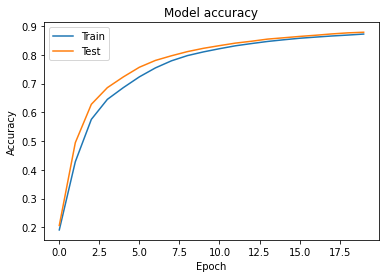

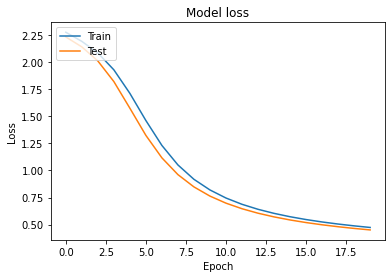

In [24]:
import matplotlib.pyplot as plt
# don't forget this next line, or else your graphs won't show up in the notebook!
%matplotlib inline      
# Plot training & validation accuracy values
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Interpreting Model Predictions

The problem we're training this network to solve is a **_Multi-Class Classification Problem_**. We know this, because there are 10 possible classes in the dataset.  The output of our network will be a vector with 10 elements. Each of these elements corresponds to a unique class in our dataset. The elements themselves will always contain a number between 0 and 1. We can interpet these numbers as the likelihood of the image being classified belonging to that class. In multi-class classification, the sum of the probabilities in our output vector will always add up to 1.0, whether we have 3 classes or 3 million. Here's an example of what an output vector might look like:

<center>[0., 0., 0.01, 0.85, 0., 0.14, 0., 0., 0., 0.]</center>

We can interpret it like this:

| Vector Output By Network | 0. | 0. | 0.01 | 0.85 | 0. | 0.14 | 0. | 0. | 0. | 0. |
|--------------------------|----|----|------|------|----|------|----|----|----|----|
| Classification           | 0  | 1  | 2    | 3    | 4  | 5    | 6  | 7  | 8  | 9  |

In this case, we would consider the classification for the corresponding image to be a **3**, because it has the largest value in our output vector. 

Let's pass in a couple images and get some predictions from our model. 

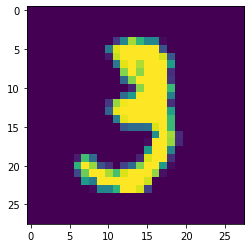

In [27]:
(sample_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
sample_image = sample_images[10]
plt.imshow(sample_image)
sample_image = np.divide(sample_image, 255.)
sample_image = np.reshape(sample_image, (1, 28, 28, 1))

In [28]:
prediction = model.predict([sample_image])

for ind, prob in enumerate(prediction[0]):
    print('Class: {} \t Likelihood: {}'.format(ind, prob))

Class: 0 	 Likelihood: 0.0003433077363297343
Class: 1 	 Likelihood: 0.0033113760873675346
Class: 2 	 Likelihood: 0.0023646827321499586
Class: 3 	 Likelihood: 0.9695296287536621
Class: 4 	 Likelihood: 6.22455581833492e-06
Class: 5 	 Likelihood: 0.01390306930989027
Class: 6 	 Likelihood: 1.2022187547700014e-05
Class: 7 	 Likelihood: 0.0010473495349287987
Class: 8 	 Likelihood: 0.009171690791845322
Class: 9 	 Likelihood: 0.00031058452441357076


Our model got it correct!

## Deliberate Practice

In this tutorial, you learned about the basics of creating data pipelines, training models, and evaluating performance using TensorFlow 2! Like anything worth doing, mastering this will take **_a lot of practice!_** To help you get started, we've provided some practice challenges. In the next part of this seminar series, we'll provide the solutions for these practice problems, and dive deep into how you can optimize your Deep Learning workflows using GPUs and TPUs, TensorFlow Callbacks, and TensorBoard! 


## Problem 1 - Experimenting With Hyperparameters

Modify the network we built in this tutorial to get better performance by changing some of the hyperparameters. We recommend things like changing the activation functions, the number of neurons in a layer, or the optimizer. Follow the links to see a full list of optimizers and activation functions in TensorFlow. (Hint: we recommend experimenting with relu, sigmoid, and tanh to compare activation functions, and playing with adam, RMSProp, and adagrad for optimizers.)

## Problem 2 - Building a better network

Create a larger, more powerful network that can reach 90% validation accuracy on the MNIST dataset. Try to limit your training to 15 epochs or less. Use whatever hyperparameters and model architecture you think is best. The sky is the limit!

